<a href="https://colab.research.google.com/github/djiraffs/Deep-Learning/blob/main/Tugas_DL_1_Income_Raffalino.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch [1/20], Loss: 646.2030
Epoch [2/20], Loss: 591.8836
Epoch [3/20], Loss: 583.0879
Epoch [4/20], Loss: 578.3811
Epoch [5/20], Loss: 576.5033
Epoch [6/20], Loss: 574.1152
Epoch [7/20], Loss: 572.7141
Epoch [8/20], Loss: 571.8712
Epoch [9/20], Loss: 570.9955
Epoch [10/20], Loss: 571.1752
Epoch [11/20], Loss: 569.2256
Epoch [12/20], Loss: 569.3924
Epoch [13/20], Loss: 569.0324
Epoch [14/20], Loss: 567.8190
Epoch [15/20], Loss: 568.1413
Epoch [16/20], Loss: 567.9501
Epoch [17/20], Loss: 566.0494
Epoch [18/20], Loss: 566.6643
Epoch [19/20], Loss: 566.3905
Epoch [20/20], Loss: 565.0916
🔹 Akurasi: 0.5727
🔹 Presisi: 0.2745
🔹 Recall: 0.3870
🔹 F1-Score: 0.3196
🔹 AUC: 0.7771


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


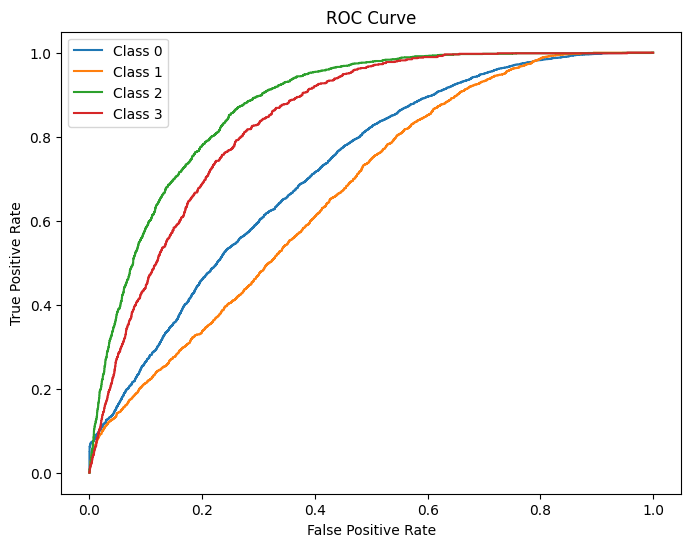

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# 🚀 **1. Load Dataset**
df = pd.read_csv("income.csv")

# 🚀 **2. Preprocessing**
# Pisahkan fitur numerik & kategori
categorical_features = df.select_dtypes(include=["object"]).columns.tolist()
numerical_features = df.select_dtypes(exclude=["object"]).columns.tolist()

# Target harus diproses terpisah
categorical_features.remove("income")

# Label Encoding untuk target
le = LabelEncoder()
df["income"] = le.fit_transform(df["income"])

# One-Hot Encoding untuk fitur kategori
df_encoded = pd.get_dummies(df, columns=categorical_features)

# Pisahkan fitur & target
X = df_encoded.drop(columns=["income"])  # Fitur
y = df_encoded["income"]  # Target

# Normalisasi fitur numerik saja
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Convert ke tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)  # Multiclass → gunakan `long`
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# 🚀 **3. Bangun Model dengan PyTorch**
class IncomeNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(IncomeNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, output_dim)  # Output multiclass
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  # Tanpa Softmax di sini (karena pakai CrossEntropyLoss)
        return x

# 🚀 **4. Inisialisasi Model**
input_dim = X_train.shape[1]
output_dim = len(np.unique(y))  # Jumlah kelas unik
model = IncomeNet(input_dim, output_dim)

# Loss Function & Optimizer
criterion = nn.CrossEntropyLoss()  # Untuk multiclass classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 🚀 **5. Training Model**
epochs = 20
batch_size = 64

train_data = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss:.4f}")

# 🚀 **6. Evaluasi Model**
model.eval()
with torch.no_grad():
    y_test_logits = model(X_test_tensor)
    y_test_pred_prob = F.softmax(y_test_logits, dim=1).numpy()  # Probabilitas
    y_test_pred = np.argmax(y_test_pred_prob, axis=1)  # Kelas prediksi

# 🚀 **7. Hitung Metrik Evaluasi**
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average="macro")
recall = recall_score(y_test, y_test_pred, average="macro")
f1 = f1_score(y_test, y_test_pred, average="macro")

# AUC untuk multiclass → Binarisasi y_test
y_test_bin = label_binarize(y_test, classes=np.unique(y))
auc = roc_auc_score(y_test_bin, y_test_pred_prob, multi_class="ovr")

print(f"🔹 Akurasi: {accuracy:.4f}")
print(f"🔹 Presisi: {precision:.4f}")
print(f"🔹 Recall: {recall:.4f}")
print(f"🔹 F1-Score: {f1:.4f}")
print(f"🔹 AUC: {auc:.4f}")

# 🚀 **8. Plot ROC Curve**
plt.figure(figsize=(8, 6))
for i in range(output_dim):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_pred_prob[:, i])
    plt.plot(fpr, tpr, label=f"Class {i}")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()